In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import random 
import time

In [2]:
def lerVideo(caminho):
    cap = cv2.VideoCapture(caminho)
    frames = []

    if not cap.isOpened():
        raise("Erro abrindo o arquivo!")

    while True: 
        ret, frame = cap.read()

        if not ret:
            print("Último frame ou erro")
            break

        frames.append(frame)

        if cv2.waitKey(1) == ord('q'):
            break

    print("Leitura completa")
    cap.release()
    return np.array(frames)

In [3]:
frames = lerVideo('EAFC24.mp4')

Último frame ou erro
Leitura completa


### Filtrando apenas objetos brancos e (roxos)

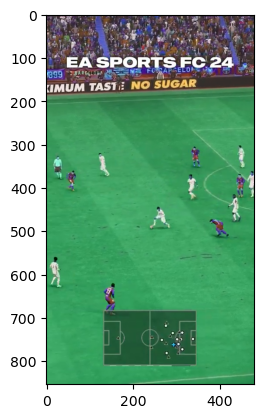

In [ ]:
img_teste = frames[400]

plt.imshow(img_teste)
plt.show()

In [35]:
def onlyWhite(img, sensitivity=90, k_size = 3):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0, 0, 255 - sensitivity])
    upper_white = np.array([255, sensitivity, 255])

    mask = cv2.inRange(img_hsv, lower_white, upper_white)

    #Openning na imagem 
    kernel = np.ones((k_size, k_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask
    
    
    #kernel = np.ones((k_size, k_size))
    #mask_opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #result = cv2.bitwise_and(img, img, mask=mask_opening)

    #return result


In [ ]:
#frames= lerVideo('EAFC24.mp4')

Último frame ou erro
Leitura completa


In [36]:
apenas_brancos = np.array([onlyWhite(frame, 110, k_size=2) for frame in frames])

In [37]:
reproduzirVideo(apenas_brancos)

#### Retirando o fundo do vídeo
Utilizando a diferença de frame em relação ao anterior

$Foreground = | I_t - I_{t-1} | > T$

In [ ]:
def difFrames(frames): 
    n = frames.shape[0];
    print(n) 
    dif = []
    for i in range(n-1, 0, -1):
        #print(i, i-1)
        dif.append(cv2.absdiff(frames[i], frames[i-1]))

    return np.array(dif[::-1])

In [ ]:
dif = difFrames(frames)

982


In [5]:
def reproduzirVideo(frames):
    for frame in frames:
        cv2.imshow("Sem fundo", frame)
        
        if cv2.waitKey(1) == ord('q'):
            break

        time.sleep(1/30)

    cv2.destroyAllWindows()


### Usando a mediana para subtrair o fundo 
$Foreground_t = |I_t - B | > T $, onde $B = median(I_1, I_2, ... , I_k)$

In [40]:
def difFramesMedian(frames, k, threshold=30):
    newFrames = [] 
    background_frames = frames[-k:]
    median_frame = np.median(background_frames, axis = 0).astype(np.uint8)


    for i, frame in enumerate(frames):
        abs_diff = cv2.absdiff(frame, median_frame)

        #abs_diff = cv2.cvtColor(abs_diff, cv2.COLOR_BGR2GRAY)

        _, foreground_mask = cv2.threshold(abs_diff, threshold, 255, cv2.THRESH_BINARY)

        newFrames.append(foreground_mask)

    return np.array(newFrames)

In [ ]:
#for k in [30, 60, 90, 120]:
#    dif = difFramesMedian(frames, k, 110)
#    reproduzirVideo(dif)

In [78]:
dif = difFramesMedian(apenas_brancos, k = 250, threshold = 230)

In [42]:
reproduzirVideo(dif)

In [79]:
#for k in [250]:
#    for t in [200, 230]:
#        dif[i] = difFramesMedian(apenas_brancos, k = k, threshold= t)
#        reproduzirVideo(dif)

In [80]:
print(dif.shape)
dif = np.expand_dims(dif, axis= -1)

print(dif.shape)

(982, 854, 480)
(982, 854, 480, 1)


In [81]:
for i, frame in enumerate(frames):
    dif[i] = cv2.bitwise_and(frame, dif[i])

error: OpenCV(4.8.1) /io/opencv/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'
